# Summary
This notebook compared 4 classifiers for airline passenger satisfaction.  
XGBoost, LGBM, and randomforrest all had an accuracy of 96%. Dense NN had an accuracy of 77%. K-means classifier had a lower accuracy of 50%.

Inflight wifi service was identified as the most important feature for predicting satisfaction.

This notebook is organized as follows:
1. EDA
2. Model training and optimization
    1. XGBoost
    2. LGBM
    3. RandomForrest
    4. NN in Keras
    5. K-means classifier
3. flask api

data from https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

tools used:
1. XGBoost
2. LGBM
3. RandomForrest
4. confusion matrix
5. feature importance
6. plots (seaborn, matlplotlib)
7. mlflow for logging
8. optuna for hyper parameter optimization
9. Pipeline, ColumnTransformer, OneHotEncoder, SimpleImputer for data preparation
10. flask api with pydantic for type checking
11. Docker for api 


lunch basic mlflow server with 

mlflow server --host 127.0.0.1 --port 8080   

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.cluster import KMeans
import optuna
import mlflow
from mlflow.models import infer_signature
import matplotlib.pyplot as plt
import seaborn as sns

mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")

/opt/anaconda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('train.csv')
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


Check column names and datatypes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         103904 non-null  int64  
 1   id                                 103904 non-null  int64  
 2   Gender                             103904 non-null  object 
 3   Customer Type                      103904 non-null  object 
 4   Age                                103904 non-null  int64  
 5   Type of Travel                     103904 non-null  object 
 6   Class                              103904 non-null  object 
 7   Flight Distance                    103904 non-null  int64  
 8   Inflight wifi service              103904 non-null  int64  
 9   Departure/Arrival time convenient  103904 non-null  int64  
 10  Ease of Online booking             103904 non-null  int64  
 11  Gate location                      1039

check if any columns have nulls

In [5]:
# drop unnamed 0 since it seems like its just the index
df = df.drop('Unnamed: 0', axis=1)
df.isnull().any()

id                                   False
Gender                               False
Customer Type                        False
Age                                  False
Type of Travel                       False
Class                                False
Flight Distance                      False
Inflight wifi service                False
Departure/Arrival time convenient    False
Ease of Online booking               False
Gate location                        False
Food and drink                       False
Online boarding                      False
Seat comfort                         False
Inflight entertainment               False
On-board service                     False
Leg room service                     False
Baggage handling                     False
Checkin service                      False
Inflight service                     False
Cleanliness                          False
Departure Delay in Minutes           False
Arrival Delay in Minutes              True
satisfactio

Check the nunique for categorical types to figure out the appropriate encoder. Since most of the categorical values have low number of unique categories, a one hot encoder might be appropriate for this data.

In [6]:
df.select_dtypes('object').nunique()

Gender            2
Customer Type     2
Type of Travel    2
Class             3
satisfaction      2
dtype: int64

# EDA

Plot the distribution of satisfaction. The plot shows that each satisfaction category has sufficient samples.  

### Strategies for Handling Imbalanced Datasets
Resampling Techniques:
1. **Oversampling**: Increase the number of instances in the minority class by duplicating existing samples or generating synthetic samples (e.g., using SMOTE).
2. **Undersampling**: Reduce the number of instances in the majority class to balance the dataset.
3. **Using Different Algorithms**: Some algorithms are better suited for handling imbalanced data. For example, tree-based methods like Random Forest or boosting methods like XGBoost can be more resilient to imbalance.
4. **Cost-sensitive Learning**: Modify the learning algorithm to penalize misclassifications of the minority class more heavily than those of the majority class.
Ensemble Methods: Combine multiple models to improve classification performance on minority classes.

<Axes: ylabel='satisfaction'>

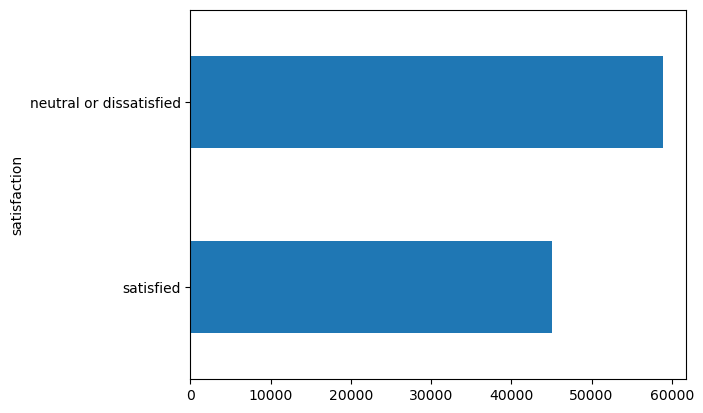

In [7]:
# fig, axes = plt.subplots()
df.satisfaction.value_counts().sort_values().plot(kind='barh')

Try to get the correlation of satisfaction to other factors.  
For simplicity, we can use label encoder for the categorical features.  
From the bottom row of the heatmap, it can be seen that most of the features have a non-zero correlation with satisfaction. This means that they could be indicators for customer satisfaction. 



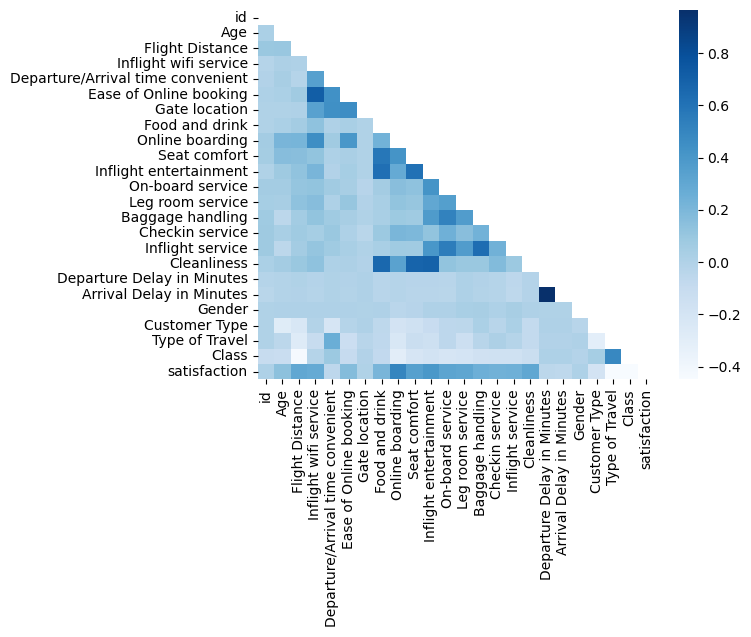

In [13]:
def plot_corr(df: pd.DataFrame):
    le = LabelEncoder()
    cat_cols = list(df.dtypes[df.dtypes == 'object'].keys())
    num_df = df.select_dtypes('number')
    for col in cat_cols:
        num_df[col] = le.fit_transform(df[col])

    corr = num_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))


    sns.heatmap(corr, mask=mask, cmap='Blues')

plot_corr(df)

Let's take a closer look of the distribution of ratings for Online boarding and Inflight wifi service vs customer satisfaction since they have the highest correlation compared to the other features.  

The plot below shows a higher satisfaction rate for people who rated online boarding 4 and 5. In contrast, those who rated online boarding 3 below have a lower satisfaction rate.  

Also, a higher satisfaction rate for inflight wifi service results in higher satisfaction rate. However, people who rated inflight wifi service of 0 maybe just did not use the wifi and are still satisfied.

<Axes: ylabel='Inflight wifi service'>

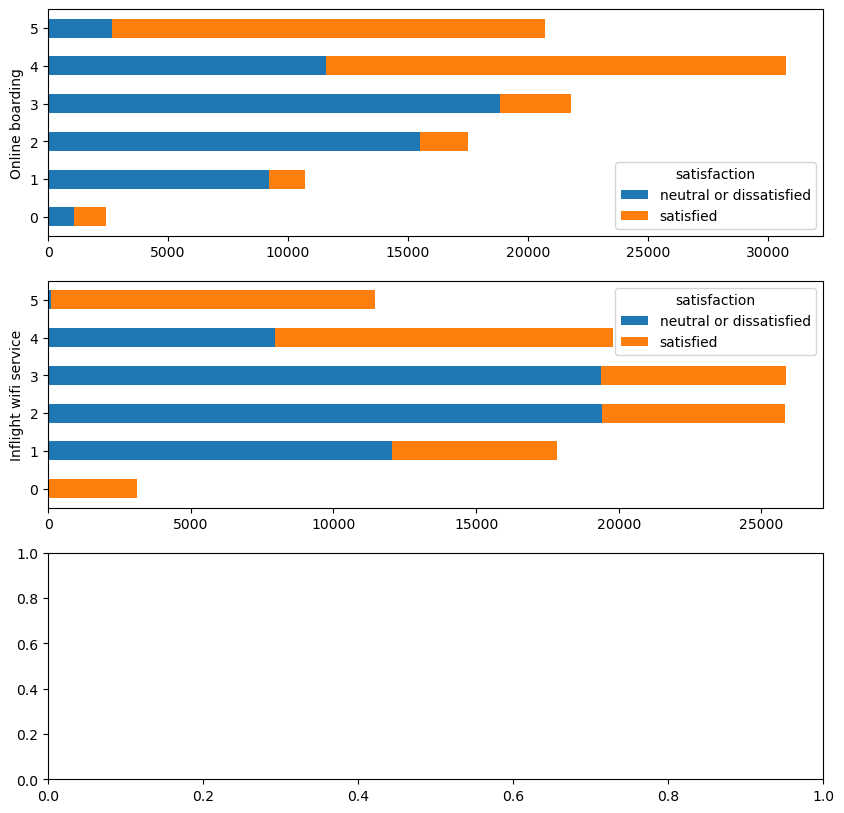

In [56]:
fig, axes = plt.subplots(3,1, figsize=(10,10))
df.groupby(['Online boarding'])['satisfaction'].value_counts().unstack().plot(kind='barh', stacked=True, ax=axes[0])
df.groupby(['Inflight wifi service'])['satisfaction'].value_counts().unstack().plot(kind='barh', stacked=True, ax=axes[1])

The plot below shows the satisfaction per age range. It can be seen that the age range 35-60 have a higher satisfaction rate than others.


/tmp/ipykernel_364154/3957012459.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  new_df.groupby('age_range')['satisfaction'].value_counts().unstack().plot(kind='barh', stacked=True)


<Axes: ylabel='age_range'>

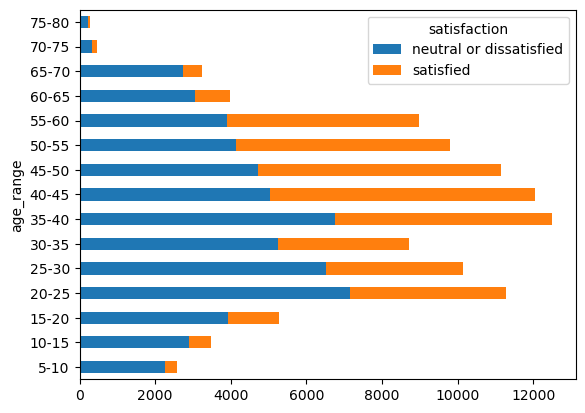

In [57]:
max_age = df['Age'].max()
min_age = df['Age'].min()

# Define bin edges every 5 years
bins = list(range(5, max_age, 5))  # This will create [20, 25, 30, 35, 40, 45, 50, 55]
labels = [f'{i}-{i+5}' for i in bins[:-1]]  # Create labels like '20-25', '25-30', etc.
new_df = df.copy()
new_df['age_range'] = pd.cut(new_df['Age'], bins=bins, labels=labels)
new_df.groupby('age_range')['satisfaction'].value_counts().unstack().plot(kind='barh', stacked=True)

# Training

Separate the target column and the features.  
Use train_test_split to randomly select training set and validation set.
Three main reasons to split data:
1. **Prevent Overfitting**: By training and testing on separate datasets, you can avoid overfitting, where a model learns to perform well on training data but fails to generalize to new data. The testing set acts as a proxy for unseen data, helping gauge true model performance 
2. **Simulate Real-World Scenarios**: In practical applications, models encounter new data that they have not seen before. The train-test split mimics this scenario by evaluating how well the model can make predictions on previously unseen examples 
3. **Measure Model Performance Accurately**: Using a separate test set allows for a more accurate assessment of model performance metrics such as accuracy, precision, recall, and F1 score. This is crucial for understanding how well a model will perform in real-world situations 

In [58]:
X = df.drop('satisfaction', axis=1)
y = pd.DataFrame(df['satisfaction'])

num_cols = X.select_dtypes('number').columns
onehot_cols = X.select_dtypes('object').columns

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
sample_row = X.iloc[0,:].to_dict()


## Why Choose Certain Models for Specific Tasks 

### Nature of the Data: 

**Linear vs. Non-linear Relationships**: If the data exhibits a linear relationship, simpler models like Linear Regression may suffice. For non-linear relationships, more complex models like Decision Trees or Neural Networks may be more appropriate. 

**Data Size and Dimensionality**: Some models handle high-dimensional data better than others. For instance, Support Vector Machines (SVM) can be effective in high-dimensional spaces, while simpler models might struggle. 

### Task Type: 

**Classification vs. Regression**: Different tasks require different approaches. For classification tasks, models like Logistic Regression, Random Forests, or Gradient Boosting are commonly used. For regression tasks, Linear Regression or more complex models like XGBoost may be preferred. 

**Time-Series Analysis**: For time-series data, models like ARIMA or LSTM (Long Short-Term Memory networks) are specifically designed to capture temporal dependencies. 

### Interpretability: 

Some applications require model interpretability (e.g., healthcare, finance). In such cases, simpler models like Decision Trees or Logistic Regression may be favored over black-box models like Neural Networks. 

### Computational Resources: 

The complexity of the model often correlates with the computational resources required. Simpler models are generally faster to train and require less memory, making them suitable for environments with limited resources. Why Choose Certain Models for Specific Tasks 


# XGBClassifier
Use simple imputer to impute nulls. Use label encoder to encode the categorical output. Use pipeline to bring it all together.  
It's good to use pipeline to avoid data leakage.

In [76]:
# Create an input example (first row of the training data)
input_example = X_train.iloc[0,:].to_numpy().reshape(1, -1) 

params = {
    'n_estimators': 100
}

num_pipleline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessing = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipleline, num_cols),
    ('cat_pipeline', cat_pipeline, onehot_cols)
])

model = XGBClassifier(**params)

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', model),
])

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_valid_encoded = le.transform(y_valid)

pipeline.fit(X_train, y_train_encoded)
preds = pipeline.predict(X_valid)
acc = accuracy_score(y_valid_encoded, preds)

# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Quickstart")

with mlflow.start_run():
    mlflow.log_params(params)

    mlflow.log_metric("accuracy", acc)

    mlflow.set_tag("Training Info", "Basic XGBClassifier model for airline satisfaction data")

    signature = infer_signature(X_train, pipeline.predict(X_train))

    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="xgboost_pipeline_model",
        signature=signature,
        input_example=input_example,
        registered_model_name="tracking-quickstart"
    )

    mlflow.log_metric("accuracy_score", acc)
    print(f'accuracy: {acc}')






/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model sche

accuracy: 0.9640382394456564


The feature importance shows that 4 features stand out as most important features compared to the rest. However, since the inputs are one-hot encoded, I don't know which features they are. :)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

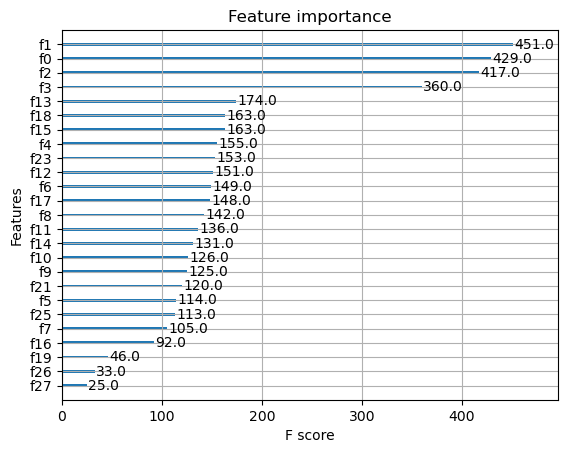

In [60]:
plot_importance(model)

In [61]:
# from mlflow.models import validate_serving_input
# loaded_model = mlflow.pyfunc.load_model('runs:/be9faf5ae7f34b67ae9118c8be5cecaf/xgboost_pipeline_model')

# loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)

# model_uri = 'runs:/be9faf5ae7f34b67ae9118c8be5cecaf/xgboost_pipeline_model'

The confusion matrix below shows that the model labeled most of the data correctly.

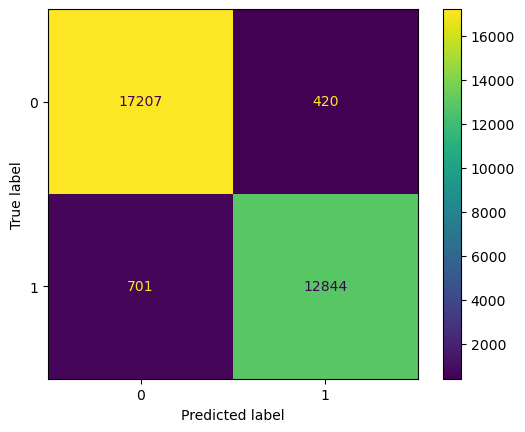

In [62]:
cm = confusion_matrix(y_valid, le.inverse_transform(preds))
ConfusionMatrixDisplay(cm).plot()

# using optuna for optimization
We can try to optimize the hyper parameters of the model using optuna. For simplicity, only the n_estimators parameter will be tuned.  
After 10 trials, the accuracy of the model has not improved from 96%.

In [63]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    clf = XGBClassifier(n_estimators=n_estimators, random_state=0)
    pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing),
        ('model', clf)
    ])
    pipeline.fit(X_train, y_train_encoded)
    return pipeline.score(X_valid, y_valid_encoded)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Extract the best trial
best_trial = study.best_trial

# Display the optimal hyperparameters and their corresponding score
print("Best Trial:")
print("  Value: {}".format(best_trial.value))
print("  Params:")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))

n_estimators = study.best_trial.params['n_estimators']
clf = XGBClassifier(n_enstimators=n_estimators, random_state=0)
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', clf)
])
pipeline.fit(X_train, y_train_encoded)


[I 2024-10-22 15:09:13,830] A new study created in memory with name: no-name-b36e9587-c8b4-453b-bc95-7f88f02b13ea
[I 2024-10-22 15:09:14,661] Trial 0 finished with value: 0.9642627999486719 and parameters: {'n_estimators': 198}. Best is trial 0 with value: 0.9642627999486719.
[I 2024-10-22 15:09:15,066] Trial 1 finished with value: 0.9646477608109842 and parameters: {'n_estimators': 66}. Best is trial 1 with value: 0.9646477608109842.
[I 2024-10-22 15:09:15,752] Trial 2 finished with value: 0.965064801745156 and parameters: {'n_estimators': 138}. Best is trial 2 with value: 0.965064801745156.
[I 2024-10-22 15:09:17,038] Trial 3 finished with value: 0.9630758372898756 and parameters: {'n_estimators': 355}. Best is trial 2 with value: 0.965064801745156.
[I 2024-10-22 15:09:18,205] Trial 4 finished with value: 0.9637174387270627 and parameters: {'n_estimators': 304}. Best is trial 2 with value: 0.965064801745156.
[I 2024-10-22 15:09:19,144] Trial 5 finished with value: 0.9637815988707815 

Best Trial:
  Value: 0.965064801745156
  Params:
    n_estimators: 138


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  Index(['id', 'Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment'...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_enstimators=138, n_estimators=None,
                               n_jobs=None, num_parallel_tree=None, ...))])

# LGBMClassifier
LGBMClassifier can handle null inputs. However, we still need to use label encoder to encode the categorical output.  

In [64]:
import string

params = {
    'n_estimators': 100
}

lgbm_clf = LGBMClassifier(**params)

X_valid_cat = X_valid.copy()
cat_cols = list(X.dtypes[X.dtypes == 'object'].keys())
X_valid_cat[cat_cols] = X_valid_cat[cat_cols].apply(lambda col: col.astype('category'))
X_valid_cat.columns = X_valid_cat.columns.str.translate(str.maketrans('', '', string.punctuation + ' '))

X_train_cat = X_train.copy()
X_train_cat[cat_cols] = X_train_cat[cat_cols].apply(lambda col: col.astype('category'))
X_train_cat.columns = X_train_cat.columns.str.translate(str.maketrans('', '', string.punctuation + ' '))

lgbm_clf.fit(X_train_cat, y_train_encoded)
preds = lgbm_clf.predict(X_valid_cat)
acc = accuracy_score(y_valid_encoded, preds)

print(classification_report(y_valid_encoded, preds))

with mlflow.start_run():
    mlflow.log_params(params)

    mlflow.log_metric("accuracy", acc)

    mlflow.set_tag("Training Info", "Basic XGBClassifier model for airline satisfaction data")

    signature = infer_signature(X_train_cat, lgbm_clf.predict(X_train_cat))

    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="lgbmclassifier_model",
        signature=signature,
        input_example=input_example,
        registered_model_name="tracking-quickstart"
    )
    print(f'accuracy: {acc}')

# print()

[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432822 -> initscore=-0.270347
[LightGBM] [Info] Start training from score -0.270347
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     17627
           1       0.97      0.94      0.96     13545

    accuracy                           0.97     31172
   macro avg       0.97      0.96      0.96     31172
weighted avg       0.97      0.97      0.97     31172



/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'tracking-quickstart' already exists. Creating a new version of this model...
2024/10/22 15:10:58 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. M

accuracy: 0.9654818426793276


This shows that inflight wifi service is the most important feature in predicting customer satisfaction.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

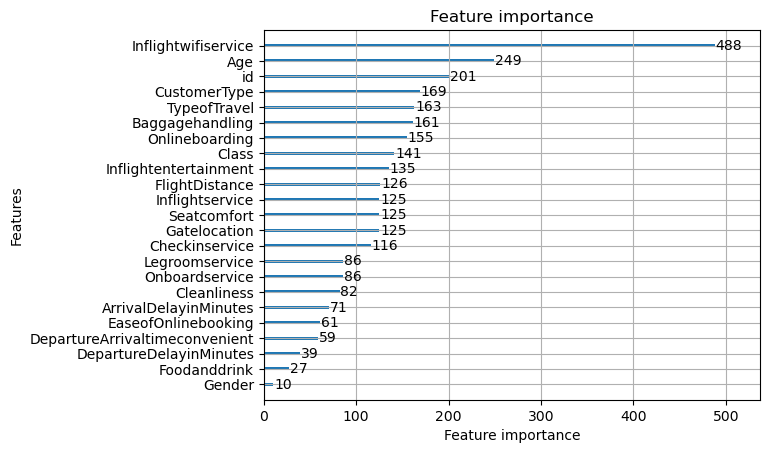

In [65]:
lgb.plot_importance(lgbm_clf)

# Optuna
Using optuna for hyper parameter optimization.

In [66]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 20, 400)
    clf = LGBMClassifier(n_estimators=n_estimators)
    clf.fit(X_train_cat, y_train_encoded)
    return clf.score(X_valid_cat, y_valid_encoded)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

n_estimators = study.best_trial.params['n_estimators']
params = {
    'n_estimators': n_estimators 
}

lgbm_clf = LGBMClassifier(n_estimators=n_estimators)
lgbm_clf.fit(X_train_cat, y_train_encoded)
preds = lgbm_clf.predict(X_valid_cat)
acc = accuracy_score(y_valid_encoded, preds)

print(classification_report(y_valid_encoded, preds))

with mlflow.start_run():
    mlflow.log_params(params)

    mlflow.log_metric("accuracy", acc)

    mlflow.set_tag("Training Info", "Basic lgbmclassifier model for airline satisfaction data")

    signature = infer_signature(X_train_cat, lgbm_clf.predict(X_train_cat))

    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="lgbmclassifier_model",
        signature=signature,
        input_example=input_example,
        registered_model_name="tracking-quickstart"
    )

    mlflow.log_metric("accuracy_score", acc)
    print(f'accuracy: {acc}')



[I 2024-10-22 15:10:59,164] A new study created in memory with name: no-name-d7d6a527-58a5-40f5-91fc-0d563005c980


[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432822 -> initscore=-0.270347
[LightGBM] [Info] Start training from score -0.270347


[I 2024-10-22 15:11:00,225] Trial 0 finished with value: 0.9666367252662647 and parameters: {'n_estimators': 352}. Best is trial 0 with value: 0.9666367252662647.


[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432822 -> initscore=-0.270347
[LightGBM] [Info] Start training from score -0.270347


[I 2024-10-22 15:11:00,747] Trial 1 finished with value: 0.9660272039009368 and parameters: {'n_estimators': 166}. Best is trial 0 with value: 0.9666367252662647.


[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432822 -> initscore=-0.270347
[LightGBM] [Info] Start training from score -0.270347


[I 2024-10-22 15:11:01,260] Trial 2 finished with value: 0.9659309636853587 and parameters: {'n_estimators': 146}. Best is trial 0 with value: 0.9666367252662647.


[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002543 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432822 -> initscore=-0.270347
[LightGBM] [Info] Start training from score -0.270347


[I 2024-10-22 15:11:01,807] Trial 3 finished with value: 0.9658988836134993 and parameters: {'n_estimators': 143}. Best is trial 0 with value: 0.9666367252662647.


[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432822 -> initscore=-0.270347
[LightGBM] [Info] Start training from score -0.270347


[I 2024-10-22 15:11:02,376] Trial 4 finished with value: 0.966315924547671 and parameters: {'n_estimators': 178}. Best is trial 0 with value: 0.9666367252662647.
[I 2024-10-22 15:11:02,535] Trial 5 finished with value: 0.9522969331451302 and parameters: {'n_estimators': 26}. Best is trial 0 with value: 0.9666367252662647.


[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432822 -> initscore=-0.270347
[LightGBM] [Info] Start training from score -0.270347
[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] 

[I 2024-10-22 15:11:03,310] Trial 6 finished with value: 0.9666046451944053 and parameters: {'n_estimators': 262}. Best is trial 0 with value: 0.9666367252662647.


[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432822 -> initscore=-0.270347
[LightGBM] [Info] Start training from score -0.270347


[I 2024-10-22 15:11:04,210] Trial 7 finished with value: 0.9665084049788272 and parameters: {'n_estimators': 303}. Best is trial 0 with value: 0.9666367252662647.


[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432822 -> initscore=-0.270347
[LightGBM] [Info] Start training from score -0.270347


[I 2024-10-22 15:11:04,607] Trial 8 finished with value: 0.9658026433979212 and parameters: {'n_estimators': 103}. Best is trial 0 with value: 0.9666367252662647.


[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432822 -> initscore=-0.270347
[LightGBM] [Info] Start training from score -0.270347


[I 2024-10-22 15:11:05,290] Trial 9 finished with value: 0.9664121647632491 and parameters: {'n_estimators': 232}. Best is trial 0 with value: 0.9666367252662647.


[LightGBM] [Info] Number of positive: 31480, number of negative: 41252
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1193
[LightGBM] [Info] Number of data points in the train set: 72732, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.432822 -> initscore=-0.270347
[LightGBM] [Info] Start training from score -0.270347
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     17627
           1       0.97      0.95      0.96     13545

    accuracy                           0.97     31172
   macro avg       0.97      0.96      0.97     31172
weighted avg       0.97      0.97      0.97     31172



/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'tracking-quickstart' already exists. Creating a new version of this model...
2024/10/22 15:12:40 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. M

accuracy: 0.9666367252662647


# RandomForrest


In [67]:
with mlflow.start_run():
    params = {
        'n_estimators': 100
    }

    rf_clf = RandomForestClassifier(**params)

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    num_pipleline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='mean'))
    ])

    preprocessing = ColumnTransformer(transformers=[
        ('num_pipeline', num_pipleline, num_cols), 
        ('cat_pipeline', cat_pipeline, cat_cols) 
    ]) 


    pipeline = Pipeline(steps=[
        ('transformer', preprocessing),
        ('model', rf_clf)
    ])

    pipeline.fit(X_train, y_train_encoded)
    preds = pipeline.predict(X_valid)
    acc = accuracy_score(y_valid_encoded, preds)

    print(classification_report(y_valid_encoded, preds))

    mlflow.log_params(params)

    mlflow.log_metric('accuracy', acc)

    mlflow.set_tag("Training Info", "Basic random forrest classifier model for airline satisfaction data")

    signature = infer_signature(X_train, pipeline.predict(X_train))

    model_info = mlflow.sklearn.log_model(
        sk_model=pipeline,
        artifact_path="randomforrestclassifier_model",
        signature=signature,
        input_example=input_example,
        registered_model_name="tracking-quickstart-randomforrest"
    )

    


              precision    recall  f1-score   support

           0       0.96      0.98      0.97     17627
           1       0.97      0.94      0.96     13545

    accuracy                           0.96     31172
   macro avg       0.97      0.96      0.96     31172
weighted avg       0.97      0.96      0.96     31172



/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'tracking-quickstart-randomforrest' already exists. Creating a new version of this model...
2024/10/22 15:14:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to fini

The feature importance shows that some features stand out as most important features compared to the rest. However, since the inputs are one-hot encoded, I don't know which features they are. :)

In [68]:
# Step 4: Extract feature importances
importances = rf_clf.feature_importances_
print(importances)

[0.02891962 0.0266396  0.02712351 0.13785172 0.01228289 0.03745086
 0.01385962 0.00933616 0.15070139 0.04524019 0.0531541  0.03161186
 0.03310443 0.02320667 0.02345585 0.02240084 0.02180427 0.00924886
 0.01043175 0.00256139 0.00275371 0.02870634 0.02306148 0.06526904
 0.04758522 0.06767244 0.04170403 0.00286215]


# NN Keras

In [77]:
from tensorflow import keras
from tensorflow.keras import layers

X_train_numeric = X_train.select_dtypes('number')
X_train_categorical = X_train.select_dtypes('object')
label_encoder = LabelEncoder()
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean'))
])

X_train_numeric_imputed = num_pipeline.fit_transform(X_train_numeric)
X_train_categorical_encoded  = cat_pipeline.fit_transform(X_train_categorical)

numeric_input = layers.Input(shape=(X_train_numeric_imputed.shape[1],))
categorical_input = layers.Input(shape=(9,))

numeric_output = layers.Dense(32, activation='relu')(numeric_input)

combined_output = layers.concatenate([numeric_output, categorical_input])

final_output = layers.Dense(32, activation='relu')(combined_output)
final_output = layers.Dense(1, activation='sigmoid')(combined_output)

model = keras.Model(inputs=[numeric_input, categorical_input], outputs=final_output)

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit([X_train_numeric_imputed, X_train_categorical_encoded], y_train_encoded.reshape(-1,1), epochs=10)

X_valid_numeric = X_valid.select_dtypes('number')
X_valid_categorical = X_valid.select_dtypes('object')
X_valid_encoded = cat_pipeline.transform(X_valid_categorical)

predictions = model.predict([X_valid_numeric, X_valid_encoded])
print(predictions[:5])  # Print first 5 predictions

Epoch 1/10


/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_231', 'keras_tensor_232']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2273/2273 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6933 - loss: 3132589.2500
Epoch 2/10
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7694 - loss: 0.4953
Epoch 3/10
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7828 - loss: 0.4845
Epoch 4/10
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7831 - loss: 0.4824
Epoch 5/10
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7804 - loss: 0.4864
Epoch 6/10
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7784 - loss: 0.4872
Epoch 7/10
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7808 - loss: 0.4850
Epoch 8/10
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 2s 994us/step - accuracy: 0.7822 - loss: 0.4824
Epoch 9/10
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7802 - loss: 0.4866
Epoch 10/10
2273/2273 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7800 - loss: 0.4846
185/975 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step

/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_231', 'keras_tensor_232']. Received: the structure of inputs=('*', '*')
  warnings.warn(


975/975 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step
[[0.776346  ]
 [0.09372243]
 [0.09491459]
 [0.7739134 ]
 [0.4767852 ]]


# K-MEANS clustering
We can also use unsupervised methods for classification.

In [73]:
cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_pipleline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(transformers=[
    ('cat_pipeline', cat_pipeline, cat_cols),
    ('num_pipleline', num_pipleline, num_cols)
])

kmeans = KMeans(n_clusters=2, init='k-means++', tol=0.0001, random_state=42)

kmeans_pipeline = Pipeline(steps=[
    ('transformer', preprocessing),
    ('model', kmeans)
])


kmeans_pipeline.fit(X_train)
preds = kmeans_pipeline.predict(X_valid)

acc = accuracy_score(y_valid_encoded, preds)
print(classification_report(y_valid_encoded, preds))

              precision    recall  f1-score   support

           0       0.57      0.51      0.54     17627
           1       0.44      0.50      0.47     13545

    accuracy                           0.50     31172
   macro avg       0.50      0.50      0.50     31172
weighted avg       0.51      0.50      0.51     31172



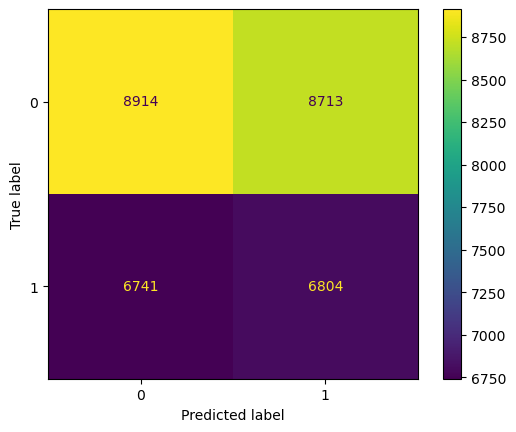

In [152]:
cm = confusion_matrix(y_valid_encoded, preds)
ConfusionMatrixDisplay(cm).plot()

In [74]:
import pickle

with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(le, file)

In [75]:
from typing import Optional
from pydantic import BaseModel, ValidationError, Field

class Flight(BaseModel):
    id: int
    gender: object = Field(..., alias='Gender')
    customer_type: object = Field(..., alias='Customer Type')
    age: int = Field(..., alias='Age')
    type_of_travel: object = Field(..., alias='Type of Travel')
    flight_class: object = Field(..., alias='Class')
    flight_distance: int = Field(..., alias='Flight Distance')
    inflight_wifi_service: int = Field(..., alias='Inflight wifi service')
    departure_arrival_time_convenient: int = Field(..., alias='Departure/Arrival time convenient')
    ease_of_online_booking: int = Field(..., alias='Ease of Online booking')
    gate_location: int = Field(..., alias='Gate location')
    food_and_drink: int = Field(..., alias='Food and drink')
    online_boarding: int = Field(..., alias='Online boarding')
    seat_comfort: int = Field(..., alias='Seat comfort')
    inflight_entertainment: int = Field(..., alias='Inflight entertainment')
    onboard_service: int = Field(..., alias='On-board service')
    leg_room_service: int = Field(..., alias='Leg room service')
    baggage_handling: int = Field(..., alias='Baggage handling')
    checkin_service: int = Field(..., alias='Checkin service')
    inflight_service: int = Field(..., alias='Inflight service')
    cleanliness: int = Field(..., alias='Cleanliness')
    departure_delay_in_minutes: int = Field(..., alias='Departure Delay in Minutes')
    arrival_delay_in_minutes: object = Field(None, alias='Arrival Delay in Minutes')

with open('pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

with open('label_encoder.pkl', 'rb') as file:
    loaded_le = pickle.load(file)

print(sample_row)
flight = Flight(**sample_row)
inputs = pd.DataFrame([flight.model_dump(by_alias=True)])
pred = loaded_pipeline.predict(inputs)
actual_pred = loaded_le.inverse_transform(pred)[0]
actual_pred



{'id': 70172, 'Gender': 'Male', 'Customer Type': 'Loyal Customer', 'Age': 13, 'Type of Travel': 'Personal Travel', 'Class': 'Eco Plus', 'Flight Distance': 460, 'Inflight wifi service': 3, 'Departure/Arrival time convenient': 4, 'Ease of Online booking': 3, 'Gate location': 1, 'Food and drink': 5, 'Online boarding': 3, 'Seat comfort': 5, 'Inflight entertainment': 5, 'On-board service': 4, 'Leg room service': 3, 'Baggage handling': 4, 'Checkin service': 4, 'Inflight service': 5, 'Cleanliness': 5, 'Departure Delay in Minutes': 25, 'Arrival Delay in Minutes': 18.0}


'neutral or dissatisfied'

In [30]:
from flask import Flask, jsonify, request

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        flight = Flight(**request.json)
        inputs = pd.DataFrame([flight.model_dump(by_alias=True)])
        pred = loaded_pipeline.predict(inputs)
        actual_pred = loaded_le.inverse_transform(pred)[0]
        response = {
            'prediction': actual_pred
        }
        return jsonify(response), 200
    except ValidationError as e:
        return jsonify(e.errors()), 400


if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Oct/2024 11:35:44] "POST /predict HTTP/1.1" 200 -
